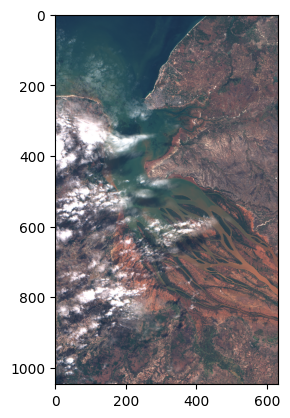

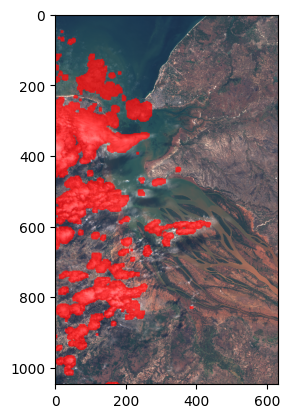

In [1]:
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    bbox_to_dimensions,
)

import matplotlib.pyplot as plot

# sentinel hub user credential
config = SHConfig()
config.sh_client_id = "e43faa9d-da0c-41c6-b8cc-20ca963c9d36"
config.sh_client_secret = ":?1&ZxLq2T&m_8U&3>^(YfL,j{SGj3-U4e{z5x?L"

# cloudy image
bbox = BBox(bbox=(46.16, -16.15, 46.51, -15.58), crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=60)

evalscripts = [
    """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
    }
    """,
    """
    //VERSION=3

    function setup() {
        return {
            input: ["B02", "B03", "B04", "CLM"],
            output: { bands: 3 }
        }
    }

    function evaluatePixel(sample) {
        if (sample.CLM == 1) {
            return [0.75 + sample.B04, sample.B03, sample.B02]
        }
        return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
    }
    """
]

for evalscript in evalscripts:

    request = SentinelHubRequest(
        config=config,
        bbox=bbox,
        size=size,
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=("2020-06-12", "2020-06-13"),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    )

    images = request.get_data()

    for image in images:
        plot.imshow(image)
        plot.show()

